In [12]:
from kan import *


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# initialize KAN with G=3
model = KAN(width=[2,1,1], grid=3, k=3, seed=1, device=device)

# create dataset
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2, device=device)

cpu
checkpoint directory created: ./model
saving model version 0.0


In [13]:
print (f)

<function <lambda> at 0x000001840724D120>


In [22]:
print (dataset['train_input'])

dataset['train_input'].shape

tensor([[-0.0075,  0.5547],
        [ 0.5364,  0.1791],
        [-0.8230,  0.1526],
        ...,
        [-0.3216, -0.4567],
        [ 0.0036, -0.3966],
        [-0.1923, -0.8376]])


torch.Size([1000, 2])

In [23]:
dataset['train_input'].shape, dataset['train_label'].shape 

(torch.Size([1000, 2]), torch.Size([1000, 1]))

In [15]:
model.fit(dataset, opt="LBFGS", steps=20);

| train_loss: 6.44e-01 | test_loss: 6.66e-01 | reg: 9.17e+00 | : 100%|█| 20/20 [00:08<00:00,  2.34it

saving model version 0.1


Потери достигают плато. мы хотим получить более тонкий KAN! The loss plateaus. we want a more fine-grained KAN!

In [16]:
# initialize a more fine-grained KAN with G=10
model = model.refine(10)

saving model version 0.2


Train KAN (grid=10)

In [17]:
model.fit(dataset, opt="LBFGS", steps=20);

| train_loss: 5.11e-01 | test_loss: 4.83e-01 | reg: 8.73e+00 | : 100%|█| 20/20 [00:07<00:00,  2.51it

saving model version 0.3


Потери становятся меньше. Это хорошо! Теперь мы можем даже итеративно делать сетки более мелкими.  The loss becomes lower. This is good! Now we can even iteratively making grids finer.

In [18]:
grids = np.array([3,10,20,50,100])


train_losses = []
test_losses = []
steps = 200
k = 3

for i in range(grids.shape[0]):
    if i == 0:
        model = KAN(width=[2,1,1], grid=grids[i], k=k, seed=1, device=device)
    if i != 0:
        model = model.refine(grids[i])
    results = model.fit(dataset, opt="LBFGS", steps=steps)
    train_losses += results['train_loss']
    test_losses += results['test_loss']

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.42e-01 | test_loss: 6.70e-01 | reg: 9.60e+00 | : 100%|█| 200/200 [01:01<00:00,  3.25


saving model version 0.1
saving model version 0.2


| train_loss: 4.84e-01 | test_loss: 4.73e-01 | reg: 9.03e+00 | : 100%|█| 200/200 [01:16<00:00,  2.63


saving model version 0.3
saving model version 0.4


| train_loss: 3.96e-01 | test_loss: 4.53e-01 | reg: 9.16e+00 | : 100%|█| 200/200 [01:30<00:00,  2.20


saving model version 0.5
saving model version 0.6


| train_loss: 3.22e-01 | test_loss: 3.74e-01 | reg: 9.29e+00 | : 100%|█| 200/200 [01:24<00:00,  2.37


saving model version 0.7
saving model version 0.8


| train_loss: 2.39e-01 | test_loss: 4.17e-01 | reg: 9.39e+00 | : 100%|█| 200/200 [02:02<00:00,  1.63

saving model version 0.9


Учебная динамика потерь отображает лестничные структуры (потери внезапно падают после уточнения сетки) Training dynamics of losses display staircase structures (loss suddenly drops after grid refinement)

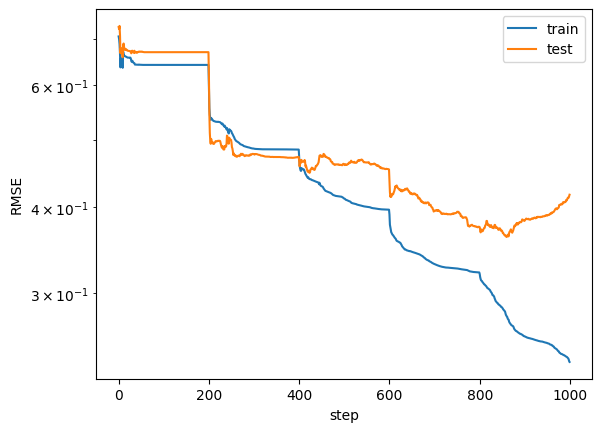

In [19]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

Нейронные законы масштабирования (По какой-то причине это стало хуже, чем в pykan 0.0. Мы все еще выясняем причину, возможно, это связано с обновлениями curve2coef)                                                                             Neural scaling laws (For some reason, this got worse than pykan 0.0. We’re still investigating the reason, probably due to the updates of curve2coef)

Text(0, 0.5, 'RMSE')

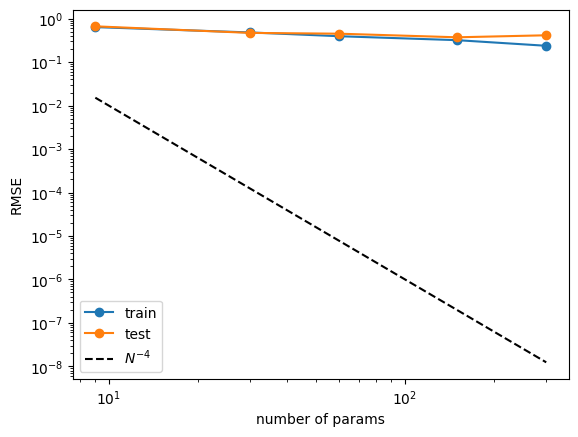

In [20]:
n_params = 3 * grids
train_vs_G = train_losses[(steps-1)::steps]
test_vs_G = test_losses[(steps-1)::steps]
plt.plot(n_params, train_vs_G, marker="o")
plt.plot(n_params, test_vs_G, marker="o")
plt.plot(n_params, 100*n_params**(-4.), ls="--", color="black")
plt.xscale('log')
plt.yscale('log')
plt.legend(['train', 'test', r'$N^{-4}$'])
plt.xlabel('number of params')
plt.ylabel('RMSE')

График должен быть как последний вот здесь внизу: https://kindxiaoming.github.io/pykan/Example/Example_1_function_fitting.html